# Imports

In [3]:
import string
import shutil
import torch
import random
import math
import h5py
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from sklearn.manifold import TSNE
from torch.optim import lr_scheduler
from google.colab import drive
from google.colab import runtime
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchsummary import summary
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install audiomentations
!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, TimeMask

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [4]:
with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/test_data.h5', 'r') as test_file:
    test_data = np.array(test_file['data'])
    test_labels = np.array(test_file['labels'])

MNIST (Testing)

In [5]:
# mean, std = 0.1307, 0.3081

# # Define transforms
# transform = v2.Compose([
#     v2.Resize((64, 64)),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize((mean,), (std,))
# ])

# # Load datasets
# train_dataset = MNIST('../data/MNIST', train=True, download=True, transform=transform)
# test_dataset = MNIST('../data/MNIST', train=False, download=True, transform=transform)

# # Define the target number of samples
# num_train_samples = 6400
# num_val_samples = 1600

# # Shuffle and select a subset of the training dataset
# train_indices = np.random.permutation(len(train_dataset))[:num_train_samples]
# train_subset = Subset(train_dataset, train_indices)

# # Shuffle and select a subset of the validation dataset
# val_indices = np.random.permutation(len(test_dataset))[:num_val_samples]
# val_subset = Subset(test_dataset, val_indices)

# # Create DataLoaders for the subsets
# kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
# train_loader = DataLoader(train_subset, shuffle=True, batch_size=256, **kwargs)
# val_loader = DataLoader(val_subset, batch_size=256, **kwargs)

Data Augmentation

In [6]:
class DataAugmentation(nn.Module):
    def __init__(self):
        super(DataAugmentation, self).__init__()
        self.transforms = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            TimeMask(min_band_part=0.1, max_band_part=0.15, p=0.5),
        ])

    def forward(self, song, sample_rate):
        augmented_song = self.transforms(song, sample_rate=sample_rate)
        return augmented_song

Create Dataset

In [7]:
class AudioDataset(Dataset):
    def __init__(self, input_data, input_labels, sample_rate=16000, n_mels=128, mean=6.5304, std=11.8924, transform=None):
        self.input_data = input_data
        self.input_labels = input_labels
        self.sr = sample_rate
        self.n_mels = n_mels
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mel_spec_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels, n_fft=2048, hop_length=512)
        self.log_mel_spec_transform = T.AmplitudeToDB()
        self.image_transforms = transform = v2.Compose([
                                                        v2.ToImage(),
                                                        v2.ToDtype(torch.float32, scale=True),
                                                        v2.Normalize((self.mean,), (self.std,))
                                                    ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song, self.sr)

        mel_spec = self.mel_spec_transform(torch.from_numpy(song))
        log_mel_spec = self.log_mel_spec_transform(mel_spec)
        mel_spec_tensor = log_mel_spec.unsqueeze(0)
        mel_spec_tensor = self.image_transforms(mel_spec_tensor)

        return mel_spec_tensor, genre

audio_train_dataset = AudioDataset(input_data=train_data, input_labels=train_labels, transform=DataAugmentation())
audio_val_dataset = AudioDataset(input_data=val_data, input_labels=val_labels, transform=None)
audio_test_dataset = AudioDataset(input_data=test_data, input_labels=test_labels, transform=None)

audio_train_loader = DataLoader(audio_train_dataset, batch_size=32, shuffle=True, pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_size=32, pin_memory=True)
audio_test_loader = DataLoader(audio_test_dataset, batch_size=32, pin_memory=True)

Display Dataloader Images

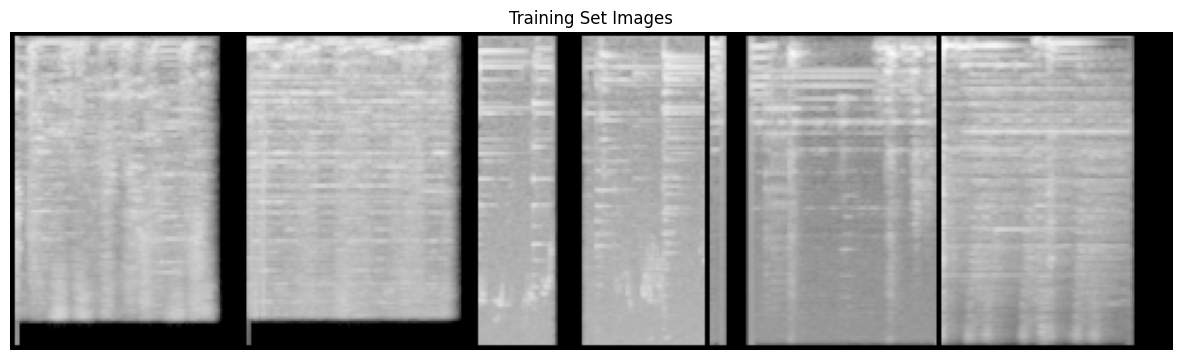

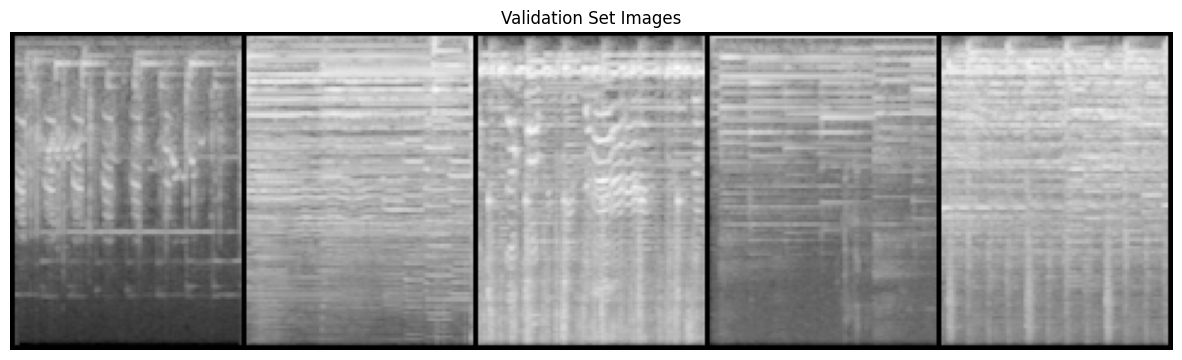

In [8]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    # Get a batch of images
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    # Select 5 random indices
    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    # Call the helper function to show images
    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(audio_train_loader, title="Training Set Images")
plot_images_from_loader(audio_val_loader, title="Validation Set Images")

Mean and Stdev Calculation

In [9]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

# Model

Print Layer (debugging)

In [10]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Positional Encoding

In [11]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding1d(nn.Module):
    def __init__(self, d_model, length):
        super(PositionalEncoding1d, self).__init__()
        if d_model % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dim (got dim={:d})".format(d_model))
        pe = torch.zeros(length, d_model)
        position = torch.arange(0, length).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                            -(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe


class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [12]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv1d, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool, two_dim: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short
        self.two_dim = two_dim

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            if self.two_dim:
              layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            else:
              layers.append(SeparableConv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            if self.two_dim:
              self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
            else:
              self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            if self.two_dim:
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            else:
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

Embedding Model

In [14]:
class ClassificationModel(nn.Module):
    def __init__(self):
      super(ClassificationModel, self).__init__()
      self.input = nn.Sequential(SeparableConv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                                 nn.SELU())
      self.positional_encoding = PositionalEncoding2d(64, 128, 130)


      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
      )

      self.attention = nn.MultiheadAttention(embed_dim=16, num_heads=2, dropout=0.5, batch_first=True)

      self.dense_layers = nn.Sequential(
          nn.Linear(in_features=256, out_features=512, bias=False),
          nn.SELU(),
          nn.Linear(in_features=512, out_features=256, bias=False),
          nn.SELU(),
          nn.Linear(in_features=256, out_features=128, bias=False),
          nn.SELU(),
          nn.Dropout(0.5),
      )

      self.output = nn.Linear(128, 8)

    def forward(self, x):
      x = self.input(x)
      # x = F.layer_norm(self.positional_encoding(x), x.shape)
      x = self.conv_layers(x)

      # batch_size, channels, height, width = x.size()
      # x = x.view(batch_size, channels, height * width)
      # attention_output, _ = self.attention(x, x, x)
      # x = F.layer_norm(x + attention_output, x.shape)

      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      out = self.output(x)
      return out

    def get_embedding(self, x):
      return self.forward(x)

# Utils

Early Stopping

In [15]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.max_accuracy = float('-inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def reset_loss(self):
        self.min_validation_loss = float('inf')

Autoclip

In [16]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [17]:
def save_checkpoint(model, optimizer, scheduler, num_epochs, train_losses, val_losses):
  checkpoint = {
          'epoch': num_epochs + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, '/content/drive/My Drive/Projects/NeuraBeat/model_checkpoint.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses

# Training Loop

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()
model = ClassificationModel().to(device)
start_epoch = 0
num_epochs = 100
learning_rate = 1e-4

classification_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10)
early_stopping = EarlyStopping(patience=3)
scaler = torch.cuda.amp.GradScaler()
autoclipper = AutoClip(percentile=10)

writer = SummaryWriter()

train_losses = []
val_losses = []

checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/model_checkpoint.pt'
if os.path.isfile(checkpoint_path):
    model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
    print(f"Loaded checkpoint from epoch {start_epoch}")

def train_loop(train_loader, model, criterion, optimizer, device, epoch):
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    total_correct = 0
    total_samples = 0

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets)

        train_loss += loss.item()
        scaler.scale(loss).backward()
        autoclipper(model)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        scaler.step(optimizer)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())

    accuracy = 100 * total_correct / total_samples
    train_loss = train_loss / num_batches
    return train_loss, accuracy, skip_lr_sched

def val_loop(val_loader, model, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == targets).sum()
            total_samples += targets.size(0)

            val_loss += loss.item()

    accuracy = 100 * total_correct / total_samples
    val_loss /= num_batches
    return val_loss, accuracy

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, train_accuracy, skip_lr_sched = train_loop(audio_train_loader, model, classification_loss_fn, optimizer, device, epoch+1)
    val_loss, val_accuracy = val_loop(audio_val_loader, model, classification_loss_fn, device, epoch+1)
    print(f"Train loss: {train_loss:>8f} - Train Accuracy: {train_accuracy:>f} - Val loss: {val_loss:>8f} - Val Accuracy: {val_accuracy:>f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses)

    # early_stop_result = early_stopping.early_stop(val_loss)
    # if early_stop_result:
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    print("Last learning rate:", scheduler.get_last_lr())
    if not skip_lr_sched:
        scheduler.step()

writer.close()

Epoch 1
-------------------------------


100%|██████████| 1782/1782 [24:22<00:00,  1.22it/s]


Train loss: 1.823961 - Train Accuracy: 29.508628 - Val loss: 1.663267 - Val Accuracy: 37.037037 

Last learning rate: [0.0001]
Epoch 2
-------------------------------


100%|██████████| 1782/1782 [24:16<00:00,  1.22it/s]


Train loss: 1.680445 - Train Accuracy: 37.047559 - Val loss: 1.605649 - Val Accuracy: 41.947250 

Last learning rate: [9.755282581475769e-05]
Epoch 3
-------------------------------


100%|██████████| 1782/1782 [24:03<00:00,  1.23it/s]


Train loss: 1.608863 - Train Accuracy: 40.747755 - Val loss: 1.545119 - Val Accuracy: 44.458477 

Last learning rate: [9.045084971874738e-05]
Epoch 4
-------------------------------


100%|██████████| 1782/1782 [24:11<00:00,  1.23it/s]


Train loss: 1.561869 - Train Accuracy: 43.273008 - Val loss: 1.522958 - Val Accuracy: 44.823235 

Last learning rate: [7.938926261462366e-05]
Epoch 5
-------------------------------


100%|██████████| 1782/1782 [24:27<00:00,  1.21it/s]


Train loss: 1.523977 - Train Accuracy: 45.259891 - Val loss: 1.428878 - Val Accuracy: 48.821552 

Last learning rate: [6.545084971874738e-05]
Epoch 6
-------------------------------


100%|██████████| 1782/1782 [24:06<00:00,  1.23it/s]


Train loss: 1.491810 - Train Accuracy: 46.860971 - Val loss: 1.404903 - Val Accuracy: 50.547142 

Last learning rate: [5e-05]
Epoch 7
-------------------------------


100%|██████████| 1782/1782 [24:09<00:00,  1.23it/s]


Train loss: 1.463807 - Train Accuracy: 48.083263 - Val loss: 1.394807 - Val Accuracy: 50.911900 

Last learning rate: [3.4549150281252636e-05]
Epoch 8
-------------------------------


100%|██████████| 1782/1782 [24:26<00:00,  1.21it/s]


Train loss: 1.443488 - Train Accuracy: 49.095118 - Val loss: 1.382674 - Val Accuracy: 51.136368 

Last learning rate: [2.061073738537635e-05]
Epoch 9
-------------------------------


100%|██████████| 1782/1782 [24:44<00:00,  1.20it/s]


Train loss: 1.430084 - Train Accuracy: 49.622966 - Val loss: 1.368756 - Val Accuracy: 52.174526 

Last learning rate: [9.549150281252633e-06]
Epoch 10
-------------------------------


100%|██████████| 1782/1782 [24:38<00:00,  1.21it/s]


Train loss: 1.423434 - Train Accuracy: 49.919332 - Val loss: 1.364878 - Val Accuracy: 52.188553 

Last learning rate: [2.4471741852423237e-06]
Epoch 11
-------------------------------


100%|██████████| 1782/1782 [24:45<00:00,  1.20it/s]


Train loss: 1.472045 - Train Accuracy: 47.892116 - Val loss: 1.427057 - Val Accuracy: 49.775536 

Last learning rate: [0.0001]
Epoch 12
-------------------------------


100%|██████████| 1782/1782 [24:48<00:00,  1.20it/s]


Train loss: 1.457643 - Train Accuracy: 48.565516 - Val loss: 1.364574 - Val Accuracy: 52.707634 

Last learning rate: [9.755282581475769e-05]
Epoch 13
-------------------------------


100%|██████████| 1782/1782 [24:33<00:00,  1.21it/s]


Train loss: 1.434612 - Train Accuracy: 49.417789 - Val loss: 1.345805 - Val Accuracy: 53.142540 

Last learning rate: [9.045084971874738e-05]
Epoch 14
-------------------------------


100%|██████████| 1782/1782 [24:35<00:00,  1.21it/s]


Train loss: 1.413058 - Train Accuracy: 50.226221 - Val loss: 1.320925 - Val Accuracy: 54.601574 

Last learning rate: [7.938926261462366e-05]
Epoch 15
-------------------------------


100%|██████████| 1782/1782 [25:18<00:00,  1.17it/s]


Train loss: 1.391212 - Train Accuracy: 51.106552 - Val loss: 1.336529 - Val Accuracy: 53.030304 

Last learning rate: [6.545084971874738e-05]
Epoch 16
-------------------------------


100%|██████████| 1782/1782 [25:49<00:00,  1.15it/s]


Train loss: 1.369070 - Train Accuracy: 52.279742 - Val loss: 1.290878 - Val Accuracy: 55.457355 

Last learning rate: [5e-05]
Epoch 17
-------------------------------


100%|██████████| 1782/1782 [25:21<00:00,  1.17it/s]


Train loss: 1.351575 - Train Accuracy: 53.096942 - Val loss: 1.278533 - Val Accuracy: 55.892258 

Last learning rate: [3.4549150281252636e-05]
Epoch 18
-------------------------------


100%|██████████| 1782/1782 [26:17<00:00,  1.13it/s]


Train loss: 1.337433 - Train Accuracy: 53.496773 - Val loss: 1.265425 - Val Accuracy: 56.453426 

Last learning rate: [2.061073738537635e-05]
Epoch 19
-------------------------------


100%|██████████| 1782/1782 [25:55<00:00,  1.15it/s]


Train loss: 1.319719 - Train Accuracy: 54.019360 - Val loss: 1.252843 - Val Accuracy: 57.042652 

Last learning rate: [9.549150281252633e-06]
Epoch 20
-------------------------------


100%|██████████| 1782/1782 [25:36<00:00,  1.16it/s]


Train loss: 1.312528 - Train Accuracy: 54.489338 - Val loss: 1.251363 - Val Accuracy: 57.281147 

Last learning rate: [2.4471741852423237e-06]
Epoch 21
-------------------------------


100%|██████████| 1782/1782 [25:37<00:00,  1.16it/s]


Train loss: 1.379263 - Train Accuracy: 51.762416 - Val loss: 1.287612 - Val Accuracy: 55.583618 

Last learning rate: [0.0001]
Epoch 22
-------------------------------


100%|██████████| 1782/1782 [25:44<00:00,  1.15it/s]


Train loss: 1.369394 - Train Accuracy: 52.027217 - Val loss: 1.286433 - Val Accuracy: 55.555557 

Last learning rate: [9.755282581475769e-05]
Epoch 23
-------------------------------


100%|██████████| 1782/1782 [25:57<00:00,  1.14it/s]


Train loss: 1.353672 - Train Accuracy: 52.711139 - Val loss: 1.280220 - Val Accuracy: 56.285076 

Last learning rate: [9.045084971874738e-05]
Epoch 24
-------------------------------


100%|██████████| 1782/1782 [25:55<00:00,  1.15it/s]


Train loss: 1.343677 - Train Accuracy: 53.305626 - Val loss: 1.255480 - Val Accuracy: 57.084740 

Last learning rate: [7.938926261462366e-05]
Epoch 25
-------------------------------


100%|██████████| 1782/1782 [24:53<00:00,  1.19it/s]


Train loss: 1.310335 - Train Accuracy: 54.529672 - Val loss: 1.232662 - Val Accuracy: 58.150955 

Last learning rate: [6.545084971874738e-05]
Epoch 26
-------------------------------


100%|██████████| 1782/1782 [25:57<00:00,  1.14it/s]


Train loss: 1.290085 - Train Accuracy: 55.190797 - Val loss: 1.241589 - Val Accuracy: 57.421440 

Last learning rate: [5e-05]
Epoch 27
-------------------------------


100%|██████████| 1782/1782 [25:44<00:00,  1.15it/s]


Train loss: 1.277126 - Train Accuracy: 55.851922 - Val loss: 1.204161 - Val Accuracy: 58.375423 

Last learning rate: [3.4549150281252636e-05]
Epoch 28
-------------------------------


100%|██████████| 1782/1782 [25:55<00:00,  1.15it/s]


Train loss: 1.257146 - Train Accuracy: 56.635802 - Val loss: 1.191322 - Val Accuracy: 59.427612 

Last learning rate: [2.061073738537635e-05]
Epoch 29
-------------------------------


100%|██████████| 1782/1782 [25:58<00:00,  1.14it/s]


Train loss: 1.249109 - Train Accuracy: 56.898850 - Val loss: 1.177766 - Val Accuracy: 59.946693 

Last learning rate: [9.549150281252633e-06]
Epoch 30
-------------------------------


100%|██████████| 1782/1782 [26:25<00:00,  1.12it/s]


Train loss: 1.241215 - Train Accuracy: 57.244318 - Val loss: 1.176234 - Val Accuracy: 60.311451 

Last learning rate: [2.4471741852423237e-06]
Epoch 31
-------------------------------


100%|██████████| 1782/1782 [26:31<00:00,  1.12it/s]


Train loss: 1.307839 - Train Accuracy: 54.517396 - Val loss: 1.208523 - Val Accuracy: 58.641979 

Last learning rate: [0.0001]
Epoch 32
-------------------------------


100%|██████████| 1782/1782 [25:23<00:00,  1.17it/s]


Train loss: 1.305284 - Train Accuracy: 54.733095 - Val loss: 1.225646 - Val Accuracy: 58.347366 

Last learning rate: [9.755282581475769e-05]
Epoch 33
-------------------------------


100%|██████████| 1782/1782 [25:12<00:00,  1.18it/s]


Train loss: 1.290677 - Train Accuracy: 55.274972 - Val loss: 1.192260 - Val Accuracy: 59.385525 

Last learning rate: [9.045084971874738e-05]
Epoch 34
-------------------------------


100%|██████████| 1782/1782 [25:21<00:00,  1.17it/s]


Train loss: 1.277697 - Train Accuracy: 55.804574 - Val loss: 1.191179 - Val Accuracy: 59.315380 

Last learning rate: [7.938926261462366e-05]
Epoch 35
-------------------------------


100%|██████████| 1782/1782 [25:44<00:00,  1.15it/s]


Train loss: 1.261137 - Train Accuracy: 56.265783 - Val loss: 1.194437 - Val Accuracy: 58.852417 

Last learning rate: [6.545084971874738e-05]
Epoch 36
-------------------------------


100%|██████████| 1782/1782 [25:27<00:00,  1.17it/s]


Train loss: 1.245301 - Train Accuracy: 56.816428 - Val loss: 1.155956 - Val Accuracy: 60.325481 

Last learning rate: [5e-05]
Epoch 37
-------------------------------


100%|██████████| 1782/1782 [25:18<00:00,  1.17it/s]


Train loss: 1.224040 - Train Accuracy: 57.817761 - Val loss: 1.156700 - Val Accuracy: 60.578007 

Last learning rate: [3.4549150281252636e-05]
Epoch 38
-------------------------------


100%|██████████| 1782/1782 [25:04<00:00,  1.18it/s]


Train loss: 1.205149 - Train Accuracy: 58.499930 - Val loss: 1.142249 - Val Accuracy: 60.592033 

Last learning rate: [2.061073738537635e-05]
Epoch 39
-------------------------------


100%|██████████| 1782/1782 [25:43<00:00,  1.15it/s]


Train loss: 1.192375 - Train Accuracy: 59.048822 - Val loss: 1.125852 - Val Accuracy: 61.181259 

Last learning rate: [9.549150281252633e-06]
Epoch 40
-------------------------------


100%|██████████| 1782/1782 [25:14<00:00,  1.18it/s]


Train loss: 1.187270 - Train Accuracy: 59.180345 - Val loss: 1.125073 - Val Accuracy: 61.560047 

Last learning rate: [2.4471741852423237e-06]
Epoch 41
-------------------------------


100%|██████████| 1782/1782 [25:21<00:00,  1.17it/s]


Train loss: 1.264567 - Train Accuracy: 56.099186 - Val loss: 1.185793 - Val Accuracy: 59.315380 

Last learning rate: [0.0001]
Epoch 42
-------------------------------


100%|██████████| 1782/1782 [25:31<00:00,  1.16it/s]


Train loss: 1.256059 - Train Accuracy: 56.434133 - Val loss: 1.178967 - Val Accuracy: 59.806400 

Last learning rate: [9.755282581475769e-05]
Epoch 43
-------------------------------


100%|██████████| 1782/1782 [25:23<00:00,  1.17it/s]


Train loss: 1.255188 - Train Accuracy: 56.541105 - Val loss: 1.149679 - Val Accuracy: 60.044895 

Last learning rate: [9.045084971874738e-05]
Epoch 44
-------------------------------


100%|██████████| 1782/1782 [25:26<00:00,  1.17it/s]


Train loss: 1.225491 - Train Accuracy: 57.686237 - Val loss: 1.229283 - Val Accuracy: 57.421440 

Last learning rate: [7.938926261462366e-05]
Epoch 45
-------------------------------


100%|██████████| 1782/1782 [25:10<00:00,  1.18it/s]


Train loss: 1.216461 - Train Accuracy: 58.180766 - Val loss: 1.117157 - Val Accuracy: 61.588104 

Last learning rate: [6.545084971874738e-05]
Epoch 46
-------------------------------


100%|██████████| 1782/1782 [25:32<00:00,  1.16it/s]


Train loss: 1.196545 - Train Accuracy: 58.875210 - Val loss: 1.122275 - Val Accuracy: 61.658253 

Last learning rate: [5e-05]
Epoch 47
-------------------------------


 83%|████████▎ | 1472/1782 [21:32<04:42,  1.10it/s]

Training and Validation Loss Plots

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

Testing Set Accuracy

In [ ]:
num_correct = 0
num_samples = 0
model.eval()

with torch.no_grad():
    for inputs, targets in audio_test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs.data, 1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)

print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/classification_model.pt")

In [ ]:
runtime.unassign()